# Multiclasificación en el amazonas

Usando imágenes satelitales, tenemos que decidir algunas condiciones

In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
import random 
import pandas as pd
from pathlib import Path

In [2]:
path = fv.untar_data(fv.URLs.PLANET_SAMPLE)

In [3]:
path.ls()

(#2) [Path('/storage/data/planet_sample/train'),Path('/storage/data/planet_sample/labels.csv')]

In [4]:
(path/'train').ls()

(#1000) [Path('/storage/data/planet_sample/train/train_8169.jpg'),Path('/storage/data/planet_sample/train/train_22725.jpg'),Path('/storage/data/planet_sample/train/train_9319.jpg'),Path('/storage/data/planet_sample/train/train_2071.jpg'),Path('/storage/data/planet_sample/train/train_17.jpg'),Path('/storage/data/planet_sample/train/train_20252.jpg'),Path('/storage/data/planet_sample/train/train_23370.jpg'),Path('/storage/data/planet_sample/train/train_30668.jpg'),Path('/storage/data/planet_sample/train/train_27855.jpg'),Path('/storage/data/planet_sample/train/train_19954.jpg')...]

In [5]:
# Cargamos las imagenes satelitales del amazonas
imgs = (path/'train').ls()

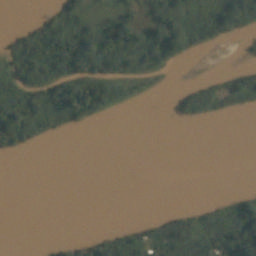

In [6]:
fv.PILImage.create(imgs[19])

In [7]:
fv.PILImage.create(imgs[19]).width

256

In [8]:
df = pd.read_csv(path/'labels.csv'); df

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road
...,...,...
995,train_1876,cloudy
996,train_10311,clear primary road water
997,train_19080,clear primary
998,train_39339,clear primary road


In [9]:
file2tags = dict(zip(df['image_name'], df['tags']))
{k: v for k, v in file2tags.items() if random.random() < 0.01}

{'train_7488': 'clear primary',
 'train_32647': 'clear primary',
 'train_33229': 'clear primary',
 'train_5355': 'clear primary',
 'train_4052': 'clear primary',
 'train_40295': 'partly_cloudy primary',
 'train_26441': 'agriculture habitation partly_cloudy primary road',
 'train_26005': 'clear primary',
 'train_2989': 'clear primary road water',
 'train_11721': 'agriculture clear habitation primary road water',
 'train_2072': 'agriculture partly_cloudy primary road',
 'train_39896': 'agriculture clear primary road',
 'train_29597': 'clear primary'}

In [10]:
def obtener_categorias(f):
    return (file2tags[f.stem])

In [11]:
obtener_categorias(imgs[19])

'clear primary water'

In [12]:
def load_data(folder, img_size, batch_size): 
    tfms = fv.aug_transforms(flip_vert=True,
                            max_rotate=360,
                            max_lighting=0.35,
                            max_zoom=1.1,
                            max_warp=0.01)
    
    data = fv.DataBlock(blocks   = (fv.ImageBlock, fv.CategoryBlock),
                       get_items = fv.get_image_files,
                       get_y     = obtener_categorias, 
                       splitter  = fv.RandomSplitter(1/10),
                       item_tfms = fv.Resize(int(1.5*img_size)),
                       batch_tfms= tfms,
                       )
    
    return (data.dataloaders(folder, bs=batch_size))

In [13]:
data = load_data(path,224,128)

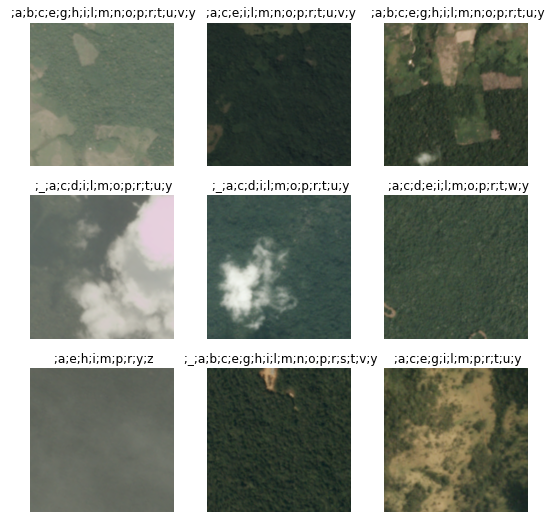

In [14]:
data.show_batch()

In [15]:
# corregimos la función de obtener categorias, ya que
# regresa únicamente el string pero yo lo quiero en lista
def obtener_categorias(f):
    # Me marcaba error con la lista, por lo tanto
    # he convertido a string y seleccionado 
    # únicamente las palabras, dejando a fuera
    # los simbolos <<[>> y <<]>>
    #print(f)
    return (file2tags[f.stem].split(' '))

In [16]:
obtener_categorias(imgs[19])

['clear', 'primary', 'water']

In [17]:


def load_data(folder, img_size, batch_size): 
    tfms = fv.aug_transforms(flip_vert=True,
                            max_rotate=360,
                            max_lighting=0.35,
                            max_zoom=1.1,
                            max_warp=0.01)
    
    data = fv.DataBlock(blocks   = (fv.ImageBlock, fv.MultiCategoryBlock),
                       get_items = fv.get_image_files,
                       get_y     = obtener_categorias, 
                       splitter  = fv.RandomSplitter(1/10),
                       item_tfms = fv.Resize(int(1.5*img_size)),
                       batch_tfms= tfms,
                       )
    
    return (data.dataloaders(folder, bs=batch_size))



In [18]:
data = load_data(path,224,128)

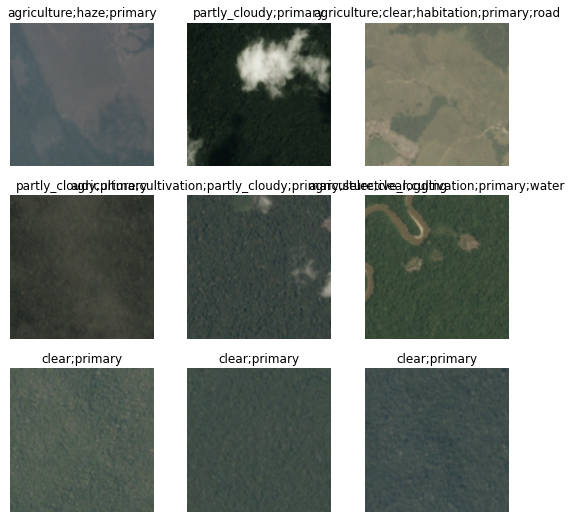

In [19]:
data.show_batch()

In [20]:
x, y = data.one_batch()

In [21]:
x.shape

torch.Size([128, 3, 336, 336])

In [22]:
y.shape

torch.Size([128, 17])

In [23]:
y[:3]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [24]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x-m)/s

In [32]:
def create_learner(**kwargs):
    learn = fv.cnn_learner(data, fv.resnet18, opt_func=fv.ranger, normalize=False, **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    #return learn.to_fp16()
    return learn

In [33]:
learn = create_learner(metrics=fv.accuracy_multi)

In [34]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

# Nuestras predicciones

Al final la red neuronal escupe 17 cosas: una por cada categoría (al igual que escupia 102 dos flores). La diferencia es que ahora en vez de conceptualmente aplicar softmax, conceptualmente aplicamos sigmoide. Cada categoria puede cumplirse o no. Independientemente de las otras.

In [35]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()



# BCE loss

¿Qué es BCEWithLogistLoss?

**BCE** Significa "Binary Cross Entropy". Es decir, hace cross entropy en CADA categoría, sólo con tu predicción.

La de "with logits" Solo significa que el modelo no te pone al final una capa sigmoidde, y entonces calcula la pérdida así (y más numéricamente estable)


In [36]:
F.binary_cross_entropy_with_logits?

In [37]:
F.binary_cross_entropy?

In [60]:
learn.lr_find()

In [59]:
learn.fit_one_cycle(1,2e-2,div=0.9,pct_start=0.75)

# Score F2

In [41]:
fv.FBetaMulti(beta=2,average="samples")

In [42]:
learn = create_learner(metrics=[fv.accuracy_multi, fv.FBetaMulti(beta=2, average="samples")])

In [44]:
learn.fit_one__cycle(4,2e-2,div=0.9,pct_start=0.75)

In [47]:


thresholds = [0.1, 0.25,0.5,0.75,0.9]
metrics = [fv.FBetaMulti(beta=2,thresh=t) for t in thresholds]

metrics += [fv.accuracy_multi]

learn = create_learner(metrics=metrics)



In [48]:
fv.AccumMetric.name = ""
thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
metrics = [fv.FBetaMulti(beta=2,thresh=t, average="samples") for t in thresholds]

for m,t in zip(metrics, thresholds):
    m.name = f"F2@{t}"
    
metrics += [fv.accuracy_multi]

In [49]:
learn = create_learner(metrics=metrics)

In [58]:
learn.fit_one_cycle(8,2e-2,div=0.9, pct_start=0.75)

In [51]:
learn.unfreeze()

In [56]:
learn.fit_one_cycle(8, slice(3e-5, 1e-3), div=0.9, pct_start=0.75)

In [53]:
thresholds = [0.1 + i*0.02 for i in range(10)]
metrics = [fv.FBetaMulti(beta=2, thresh=t, average="samples") for t in thresholds]

for m,t in zip(metrics, thresholds):
    m.name = f"F2@{t}"
    
metrics += [fv.accuracy_multi]

In [54]:
learn.metrics = metrics

In [57]:
learn.validate()